In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install torch torchvision xgboost scikit-learn tqdm joblib

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os
import random

### Load Dataset

In [ ]:
data_dir = '/content/drive/MyDrive/ML remotesensing/HW5/data/UCMerced_LandUse/Images'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
class_names = dataset.classes
print(f"Total images: {len(dataset)}")
print(f"Classes ({len(class_names)}):", class_names)

Total images: 2100
Classes (21): ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Load Pre-trained ResNet and Extract Features


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(weights='DEFAULT')
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
resnet.to(device)
resnet.eval()

features, labels = [], []

with torch.no_grad():
    for imgs, lbls in tqdm(loader):
        imgs = imgs.to(device)
        out = resnet(imgs)
        out = out.view(out.size(0), -1)
        features.append(out.cpu().numpy())
        labels.append(lbls.numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)
print(f"Feature shape: {features.shape}")
print("Labels shape:", labels.shape)


### Save Features and Labels

In [ ]:
save_path = '/content/drive/MyDrive/ML remotesensing/HW5/data/UCMerced_LandUse/features'

os.makedirs(save_path, exist_ok=True)

np.save(os.path.join(save_path, 'features.npy'), features)
np.save(os.path.join(save_path, 'labels.npy'), labels)

print("Saved feature and label arrays to Google Drive.")


### Load Features to Train XGBoost

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

save_path = '/content/drive/MyDrive/ML remotesensing/HW5/data/UCMerced_LandUse/features'

X = np.load(os.path.join(save_path, 'features.npy'))
y = np.load(os.path.join(save_path, 'labels.npy'))


### Split Data into Train/Test, Class-Balanced Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Train XGBoost

In [ ]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

### Save the Trained Classifier

In [ ]:
joblib.dump(xgb, os.path.join(save_path, 'xgb_ucmerced.pkl'))
print("Model saved successfully.")

Model saved successfully.


### Evaluation on Test Set

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

print("Evaluation Metrics")
print("----------------------")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}\n")

# Detailed per-class report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


📈 Evaluation Metrics
----------------------
Accuracy:  0.9357
Precision: 0.9378
Recall:    0.9357
F1-score:  0.9360

Detailed Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.95      1.00      0.98        20
         airplane       1.00      1.00      1.00        20
  baseballdiamond       1.00      0.95      0.97        20
            beach       1.00      1.00      1.00        20
        buildings       0.78      0.90      0.84        20
        chaparral       1.00      1.00      1.00        20
 denseresidential       0.84      0.80      0.82        20
           forest       0.95      0.95      0.95        20
          freeway       0.95      0.90      0.92        20
       golfcourse       0.95      0.95      0.95        20
           harbor       1.00      1.00      1.00        20
     intersection       0.77      0.85      0.81        20
mediumresidential       0.85      0.85      0.85        20
   mobilehomepark       

### Confusion Matrices

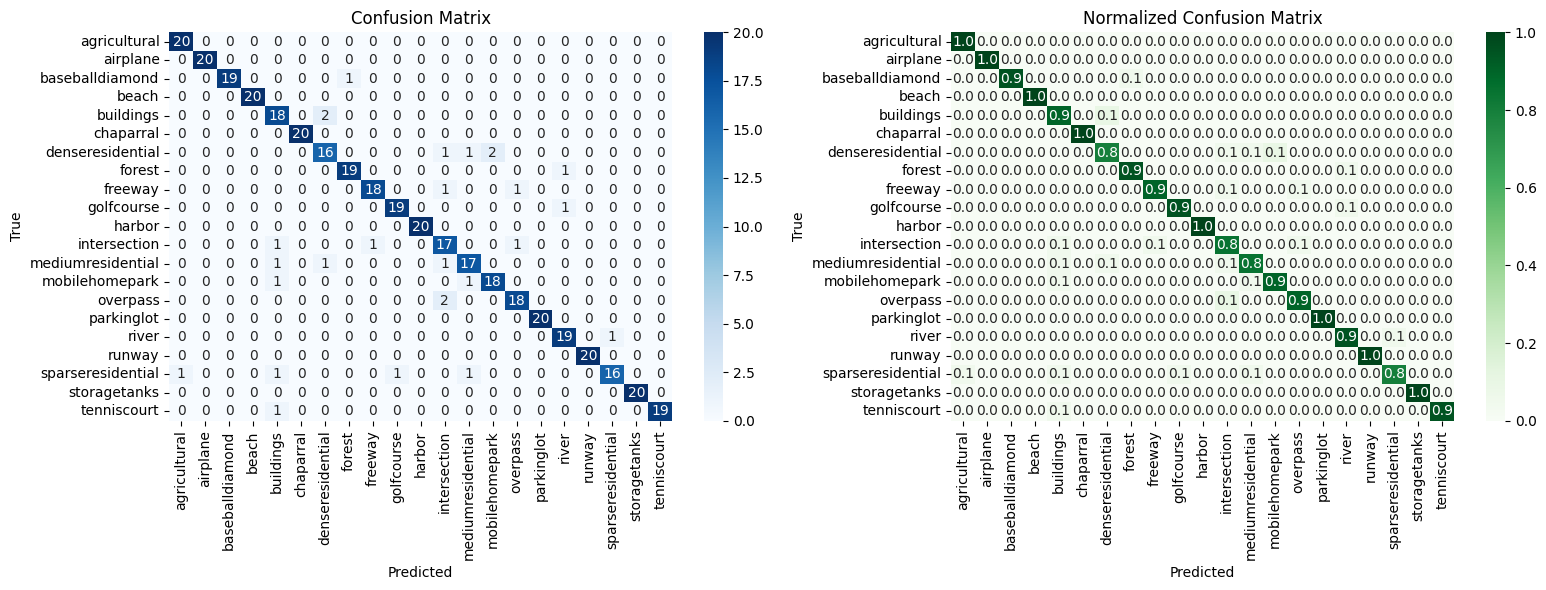

In [ ]:
#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by true class counts

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Normalized confusion matrix
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Normalized Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


Analysis of XGBoost Performance

The features extracted using a pretrained ResNet-50 model, when fed as input to train XGBoost, demonstrate remarkable performance, achieving 93.5% accuracy along with balanced precision and recall values.

# Fine-tuning a Pretrained Model – Training Only the Head

### Data Loading and Splitting

In [ ]:
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                       generator=torch.Generator().manual_seed(seed))


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet
model = models.resnet50(weights='DEFAULT')

# Freeze all base layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 21 classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(class_names))

model = model.to(device)
print("Model ready on", device)


Model ready on cuda


### Optimizer, Loss, Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)  # optional


### Training Loop

In [ ]:
num_epochs = 20
best_val_loss = float('inf')
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

save_path = "/content/drive/MyDrive/ML remotesensing/HW5/UCMerced_transfer_resnet50.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

    if val_loss < best_val_loss:

        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved best model!")

    scheduler.step()


Epoch 1/20: 100%|██████████| 46/46 [00:14<00:00,  3.23it/s]


Epoch 1/20: Train Loss 2.1318, Val Loss 1.3620, Val Acc 0.8508
Saved best model!


Epoch 2/20: 100%|██████████| 46/46 [00:15<00:00,  2.99it/s]


Epoch 2/20: Train Loss 1.0486, Val Loss 0.8516, Val Acc 0.8889
Saved best model!


Epoch 3/20: 100%|██████████| 46/46 [00:15<00:00,  2.95it/s]


Epoch 3/20: Train Loss 0.7134, Val Loss 0.6787, Val Acc 0.9048
Saved best model!


Epoch 4/20: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]


Epoch 4/20: Train Loss 0.5411, Val Loss 0.5788, Val Acc 0.9016
Saved best model!


Epoch 5/20: 100%|██████████| 46/46 [00:14<00:00,  3.09it/s]


Epoch 5/20: Train Loss 0.4604, Val Loss 0.5239, Val Acc 0.9111
Saved best model!


Epoch 6/20: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]


Epoch 6/20: Train Loss 0.3958, Val Loss 0.4711, Val Acc 0.9048
Saved best model!


Epoch 7/20: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]


Epoch 7/20: Train Loss 0.3384, Val Loss 0.4455, Val Acc 0.9016
Saved best model!


Epoch 8/20: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]


Epoch 8/20: Train Loss 0.3136, Val Loss 0.4219, Val Acc 0.9143
Saved best model!


Epoch 9/20: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]


Epoch 9/20: Train Loss 0.2836, Val Loss 0.3936, Val Acc 0.9143
Saved best model!


Epoch 10/20: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]


Epoch 10/20: Train Loss 0.2733, Val Loss 0.3892, Val Acc 0.9175
Saved best model!


Epoch 11/20: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]


Epoch 11/20: Train Loss 0.2614, Val Loss 0.3729, Val Acc 0.9143
Saved best model!


Epoch 12/20: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]


Epoch 12/20: Train Loss 0.2351, Val Loss 0.3706, Val Acc 0.9143
Saved best model!


Epoch 13/20: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]


Epoch 13/20: Train Loss 0.2226, Val Loss 0.3476, Val Acc 0.9238
Saved best model!


Epoch 14/20: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]


Epoch 14/20: Train Loss 0.2144, Val Loss 0.3462, Val Acc 0.9238
Saved best model!


Epoch 15/20: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]


Epoch 15/20: Train Loss 0.2060, Val Loss 0.3254, Val Acc 0.9365
Saved best model!


Epoch 16/20: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s]


Epoch 16/20: Train Loss 0.1954, Val Loss 0.3340, Val Acc 0.9333


Epoch 17/20: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


Epoch 17/20: Train Loss 0.1935, Val Loss 0.3251, Val Acc 0.9365
Saved best model!


Epoch 18/20: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]


Epoch 18/20: Train Loss 0.1813, Val Loss 0.3265, Val Acc 0.9270


Epoch 19/20: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]


Epoch 19/20: Train Loss 0.1863, Val Loss 0.3233, Val Acc 0.9302
Saved best model!


Epoch 20/20: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s]


Epoch 20/20: Train Loss 0.1840, Val Loss 0.3159, Val Acc 0.9365
Saved best model!


### Plot Training & Validation Loss

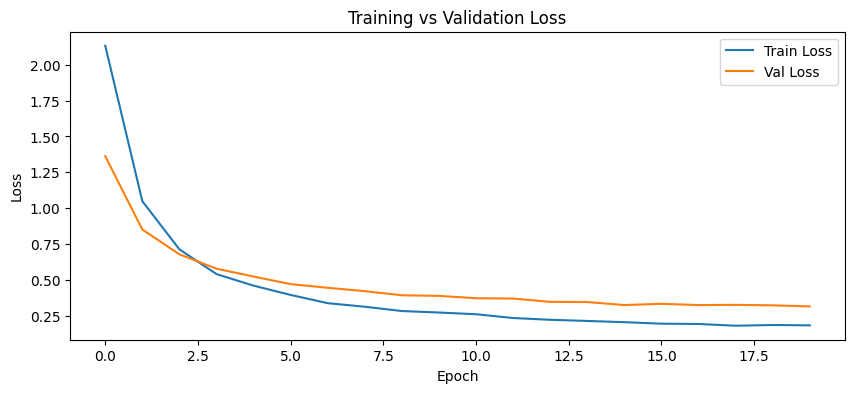

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

### Report Metrics on Test Set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

model.load_state_dict(torch.load(save_path))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("📊 Evaluation Report")
print("-------------------")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}\n")

print("Per-Class Performance:")
print(classification_report(y_true, y_pred, target_names=class_names))


📊 Evaluation Report
-------------------
Accuracy:  0.9397
Precision: 0.9479
Recall:    0.9397
F1-score:  0.9405

Per-Class Performance:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        19
         airplane       1.00      1.00      1.00        11
  baseballdiamond       1.00      1.00      1.00        15
            beach       1.00      1.00      1.00        16
        buildings       0.75      1.00      0.86        12
        chaparral       1.00      1.00      1.00        18
 denseresidential       0.69      0.90      0.78        10
           forest       0.89      1.00      0.94        17
          freeway       0.93      0.88      0.90        16
       golfcourse       1.00      1.00      1.00        11
           harbor       1.00      1.00      1.00        14
     intersection       0.80      0.86      0.83        14
mediumresidential       0.95      0.86      0.90        21
   mobilehomepark       1.00      0.9

### Confusion Matrices

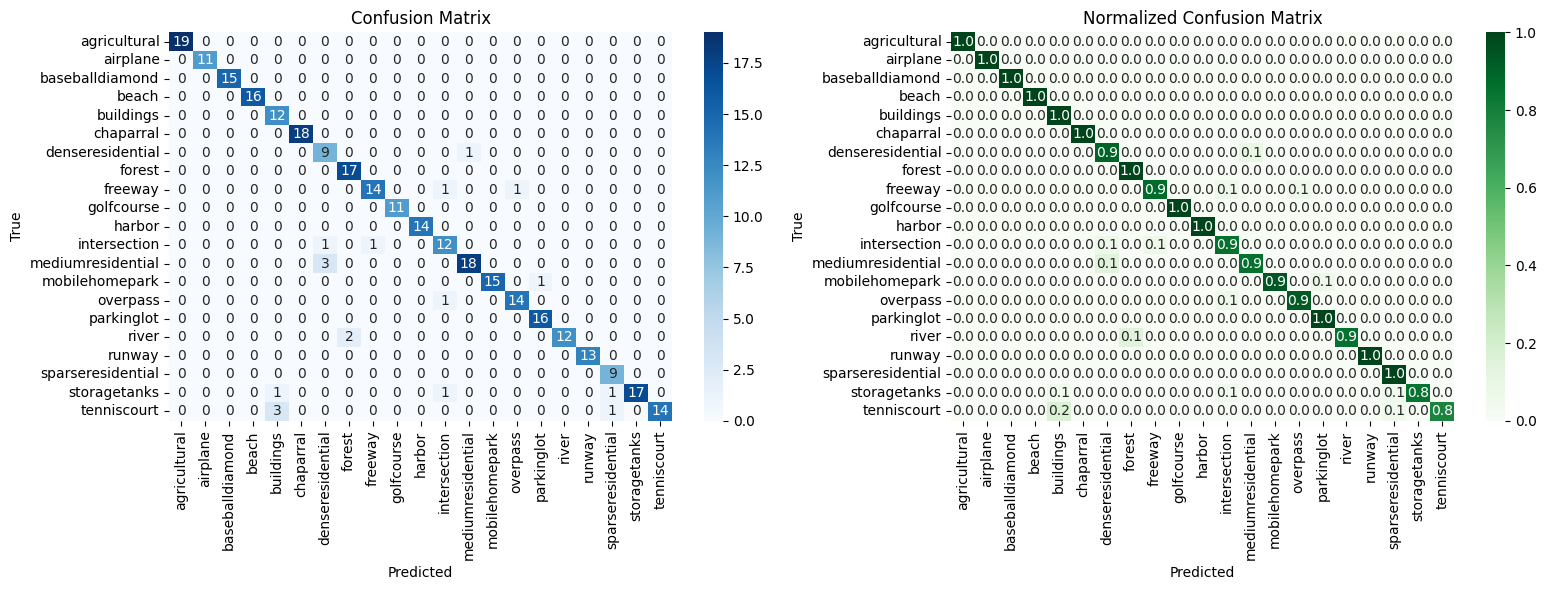

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Normalized Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


Adding a classification head and fine-tuning only this head led to performance similar to that achieved by relying solely on pretrained weights and subsequently using a traditional ML classifier. This approach differ from previous approach as it adjust the final layer weights to direct model towards accurate predictions.

## Fine-tuning a Pretrained Model – Retraining the Entire Network

### Model Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights='DEFAULT')

# Replace final FC layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(class_names))

# Unfreeze all layers for full fine-tuning
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)
print("Model ready for full fine-tuning on", device)


Model ready for full fine-tuning on cuda


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)  # optional


### Training Loop

In [ ]:
num_epochs = 10
best_val_loss = float('inf')
train_losses, val_losses = [], []
train_accs, val_accs = [], []

save_path = '/content/drive/MyDrive/ML remotesensing/HW5/UCMerced_resnet50_fullfinetune.pth'

for epoch in range(num_epochs):
    model.train()
    total_train_loss, correct_train, total_train = 0.0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = total_train_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    total_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = total_val_loss / len(val_loader.dataset)
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved best model at epoch", epoch+1)

    scheduler.step()

print("Training complete.")


Epoch 1/10: 100%|██████████| 46/46 [00:25<00:00,  1.81it/s]


Epoch 1/10 | Train Loss: 2.2482 | Val Loss: 0.9380 | Val Acc: 0.8540
Saved best model at epoch 1


Epoch 2/10: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


Epoch 2/10 | Train Loss: 0.4801 | Val Loss: 0.2102 | Val Acc: 0.9429
Saved best model at epoch 2


Epoch 3/10: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


Epoch 3/10 | Train Loss: 0.1278 | Val Loss: 0.1289 | Val Acc: 0.9683
Saved best model at epoch 3


Epoch 4/10: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


Epoch 4/10 | Train Loss: 0.0640 | Val Loss: 0.0964 | Val Acc: 0.9714
Saved best model at epoch 4


Epoch 5/10: 100%|██████████| 46/46 [00:27<00:00,  1.65it/s]


Epoch 5/10 | Train Loss: 0.0300 | Val Loss: 0.0886 | Val Acc: 0.9651
Saved best model at epoch 5


Epoch 6/10: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


Epoch 6/10 | Train Loss: 0.0291 | Val Loss: 0.0851 | Val Acc: 0.9714
Saved best model at epoch 6


Epoch 7/10: 100%|██████████| 46/46 [00:26<00:00,  1.72it/s]


Epoch 7/10 | Train Loss: 0.0195 | Val Loss: 0.0873 | Val Acc: 0.9746


Epoch 8/10: 100%|██████████| 46/46 [00:24<00:00,  1.86it/s]


Epoch 8/10 | Train Loss: 0.0194 | Val Loss: 0.0821 | Val Acc: 0.9714
Saved best model at epoch 8


Epoch 9/10: 100%|██████████| 46/46 [00:27<00:00,  1.65it/s]


Epoch 9/10 | Train Loss: 0.0130 | Val Loss: 0.1148 | Val Acc: 0.9619


Epoch 10/10: 100%|██████████| 46/46 [00:24<00:00,  1.86it/s]


Epoch 10/10 | Train Loss: 0.0088 | Val Loss: 0.0968 | Val Acc: 0.9683
Training complete.


### Plot Training & Validation Loss

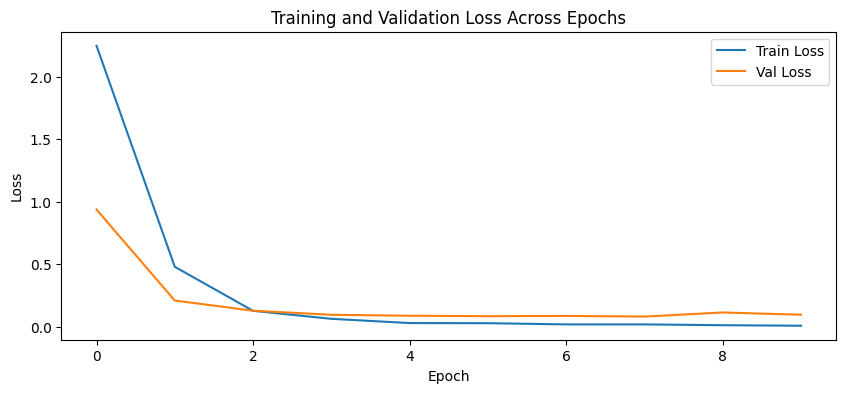

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.show()


### Evaluation on Test Set

In [ ]:
model.load_state_dict(torch.load(save_path))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true, y_pred = np.array(y_true), np.array(y_pred)


### Report Metrics

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("Test Performance Metrics")
print("---------------------------")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}\n")

print("Per-Class Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


📈 Test Performance Metrics
---------------------------
Accuracy:  0.9873
Precision: 0.9882
Recall:    0.9873
F1-score:  0.9872

Per-Class Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        19
         airplane       1.00      1.00      1.00        11
  baseballdiamond       1.00      1.00      1.00        15
            beach       1.00      1.00      1.00        16
        buildings       0.92      1.00      0.96        12
        chaparral       1.00      1.00      1.00        18
 denseresidential       1.00      0.90      0.95        10
           forest       1.00      1.00      1.00        17
          freeway       1.00      1.00      1.00        16
       golfcourse       1.00      1.00      1.00        11
           harbor       1.00      1.00      1.00        14
     intersection       0.93      1.00      0.97        14
mediumresidential       0.95      1.00      0.98        21
   mobilehomepark       1.0

### Confusion Matrices



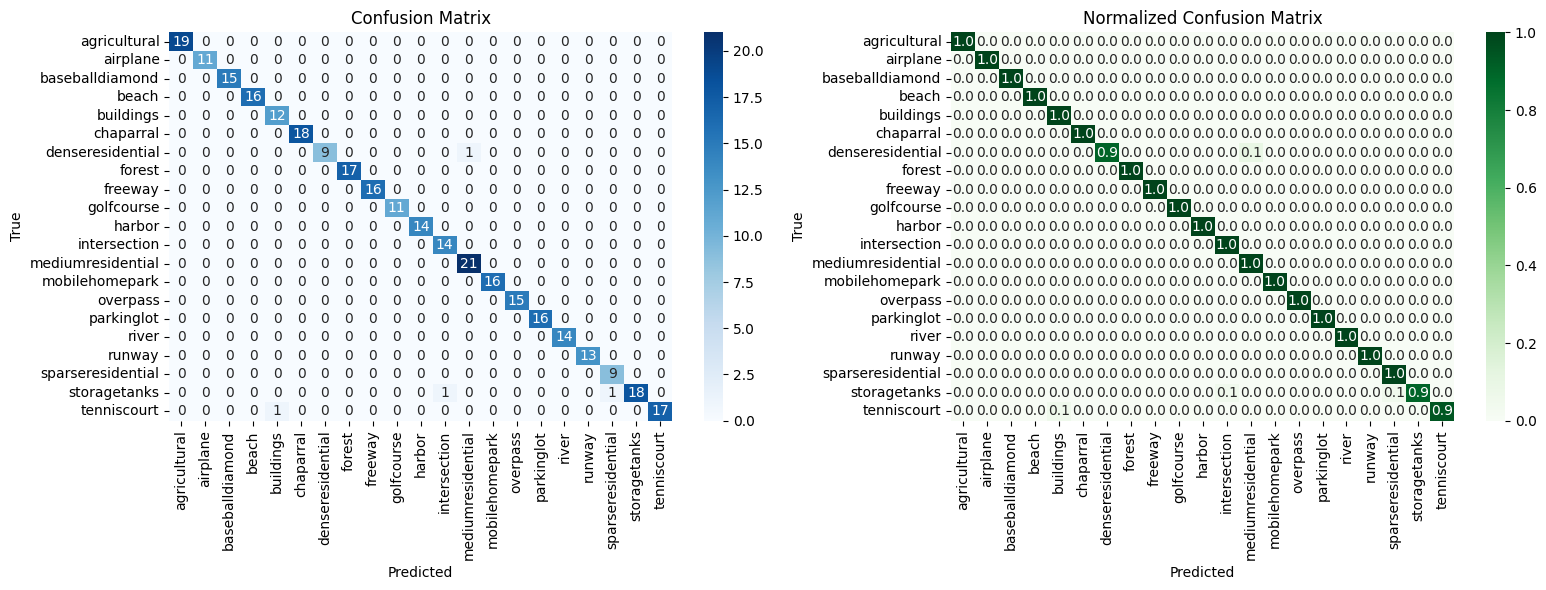

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Normalized Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


Using full model fine-tuning, we obtained the best performance (99 % accuracy) compared to relying solely on pretrained models (93 % accuracy) or adding classification heads (93 % accuracy). Full fine-tuning allows the model to recalibrate all of its weights and adjust based on the training data, leading to better outcomes. In contrast, the first approach has not seen the data during training, and the second approach, which modifies only the final layer weights, imposes more restrictions on the model's learnable parameters, resulting in poorer performance compared to full fine-tuning.

That said, it is important to note that although full model fine-tuning achieved strong performance on the current dataset, it may reduce the model's generalization ability. When exposed to data from a different domain, the fully fine-tuned model is more susceptible to failure compared to a pretrained model or one with only the classification head fine-tuned.